In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

from matplotlib import cm
from tqdm import tqdm
from scipy import interpolate
import time
from tslearn import metrics
from tslearn.metrics import dtw, dtw_path
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation
from scipy.spatial.distance import cdist
from numba import njit, prange
import numba

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')
import stumpy  # local load

# DSLBMP
DS: down sampling => PAA method  
LB: Lower bound  
MP: Matrix Profile

# Why DSLBMP over LBMP?
As I mentioned in trial3, LB is correlated to dtw.
Actually DSLB also is correlated to dtw. DSLB is less accurate,
So DSLB is used in stages depending on the rate of sampling.

<img src="images_dtw/dtw lb corrleation2.png" width="800">
<img src="images_dtw/dslbmps0.png" width="500">

## 1.PAA (8:1)

In [3]:
np.random.seed(0)
n_ts, sz, d = 2, 100, 1
dataset = random_walks(n_ts=n_ts, sz=sz, d=d)
scaler0 = TimeSeriesScalerMeanVariance(mu=0, std=1)
scaler1 = TimeSeriesScalerMeanVariance(mu=0.5, std=1.8)
dataset_scaled0 = scaler0.fit_transform(dataset)
dataset_scaled1 = scaler1.fit_transform(dataset)

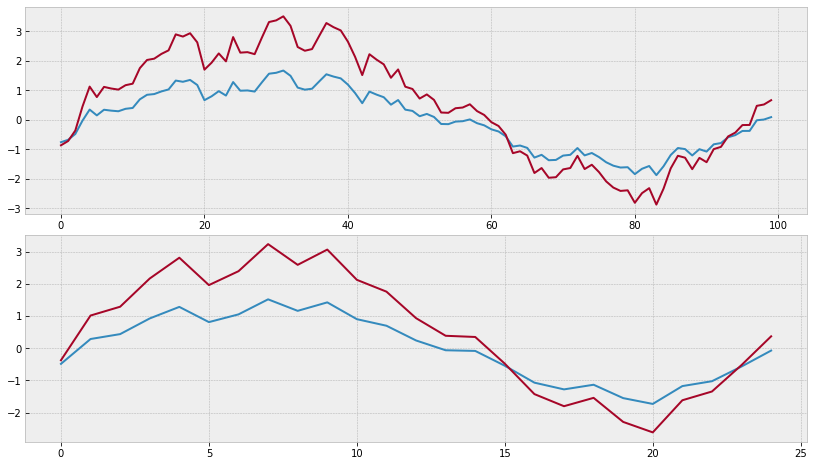

In [4]:
D = 4
paa = PiecewiseAggregateApproximation(n_segments=int(sz/D))
inv = paa.inverse_transform(paa.fit_transform(dataset_scaled0))
a_d = paa.fit_transform(dataset_scaled0)[0, :]
b_d = paa.fit_transform(dataset_scaled1)[0, :]

fig, axs = plt.subplots(2, 1, gridspec_kw={'hspace': 0.1}, figsize=(14, 8))
axs[0].plot(dataset_scaled0[0, :])
axs[0].plot(dataset_scaled1[0, :])
axs[1].plot(a_d)
axs[1].plot(b_d)

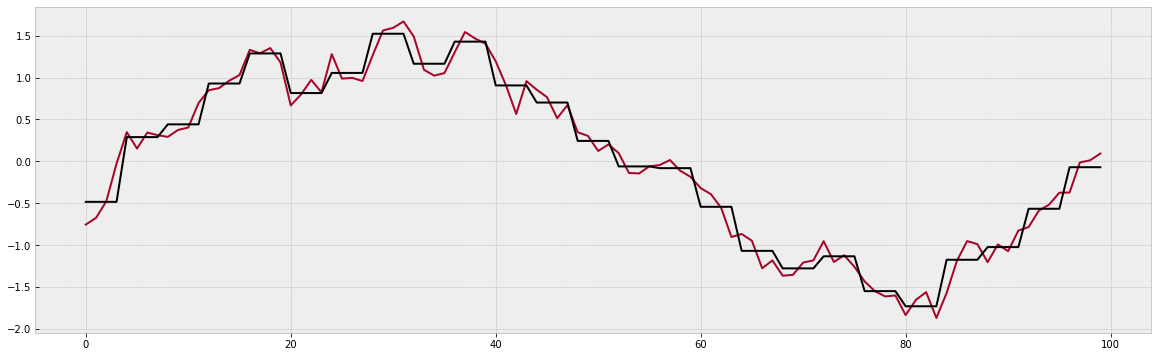

In [5]:
plt.plot(dataset_scaled0[0, :, 0], color="C1")
plt.plot(inv[0], color="k")
plt.show()

## 2.LBDS (LB with PAA)

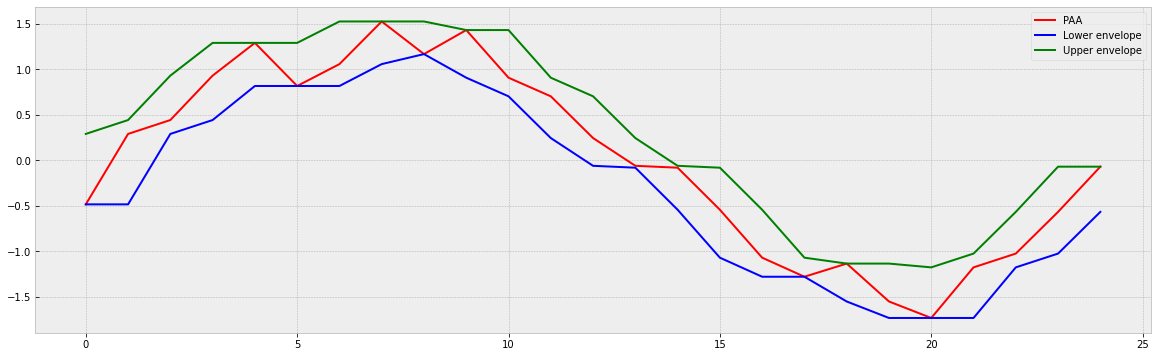

In [6]:
envelope_down, envelope_up = metrics.lb_envelope(a_d, radius=1)
plt.plot(a_d, "r-", label='PAA')
plt.plot(envelope_down[:, 0], "b-", label='Lower envelope')
plt.plot(envelope_up[:, 0], "g-", label='Upper envelope')
plt.legend()
plt.show()

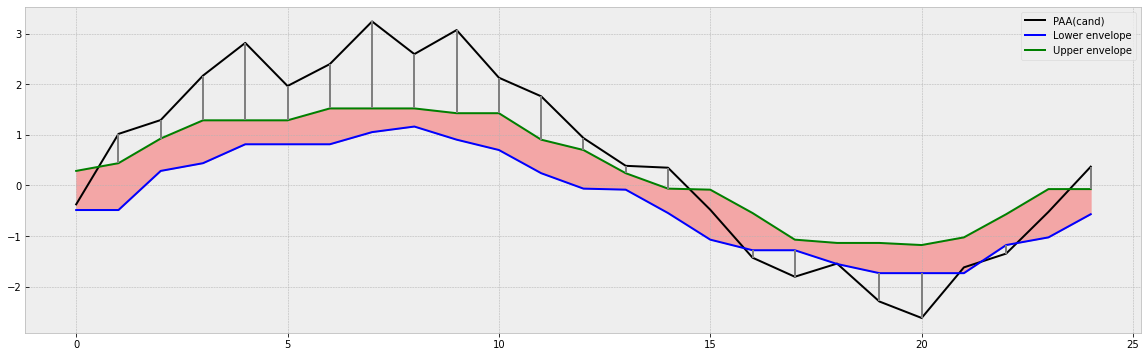

In [7]:
x_ = np.arange(envelope_down[:, 0].shape[0])

plt.plot(b_d, "k", label='PAA(cand)')
plt.plot(envelope_down[:, 0], "b-", label='Lower envelope')
plt.plot(envelope_up[:, 0], "g-", label='Upper envelope')
plt.fill_between(x_, envelope_down[:, 0], envelope_up[:, 0], color="r", alpha=0.3)
plt.vlines(x_, b_d, 
    np.clip(b_d.flatten(), envelope_down[:, 0], envelope_up[:, 0]), color='grey', linewidth=2)
plt.legend()
plt.show()

## 3.DSLBMP

<img src="images_dtw/DSLBMP flow.png" width="300">

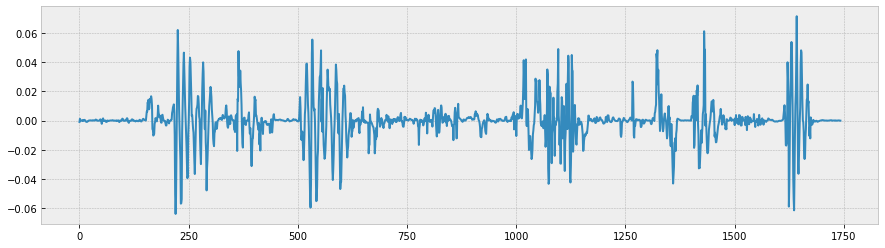

In [2]:
dfx = pd.read_csv("a1_va3.pkl")
v = dfx.values[:, 1]
plt.figure(figsize=(15, 4))
plt.plot(v)
plt.show()

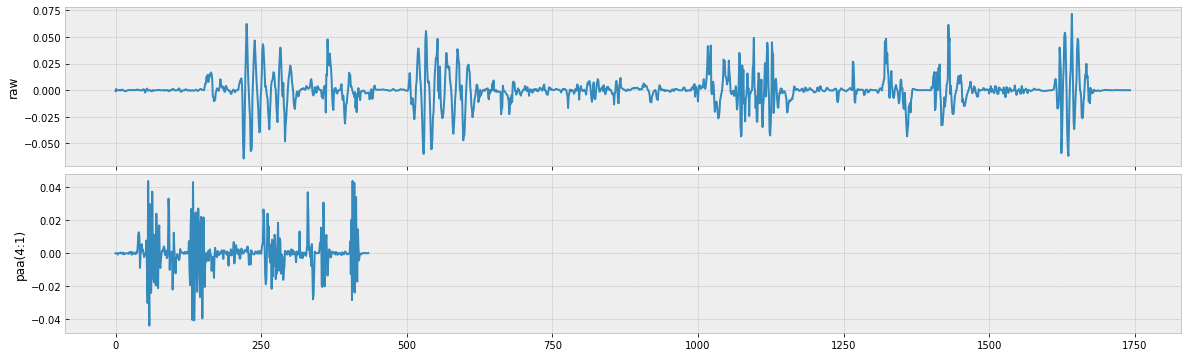

In [34]:
def paa(ts, ratio):
    n_ts = len(ts)
    n_seg = n_ts // ratio
    ts_window = ts[:n_seg*ratio].reshape(n_seg, ratio)
    ts_paa = np.mean(ts_window, axis=1)
    return ts_paa

v_paa = paa(v, 4)

fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0.05})
axs[0].plot(v)
axs[0].set_ylabel("raw")
axs[1].plot(v_paa)
axs[1].set_ylabel("paa(4:1)")
plt.show()

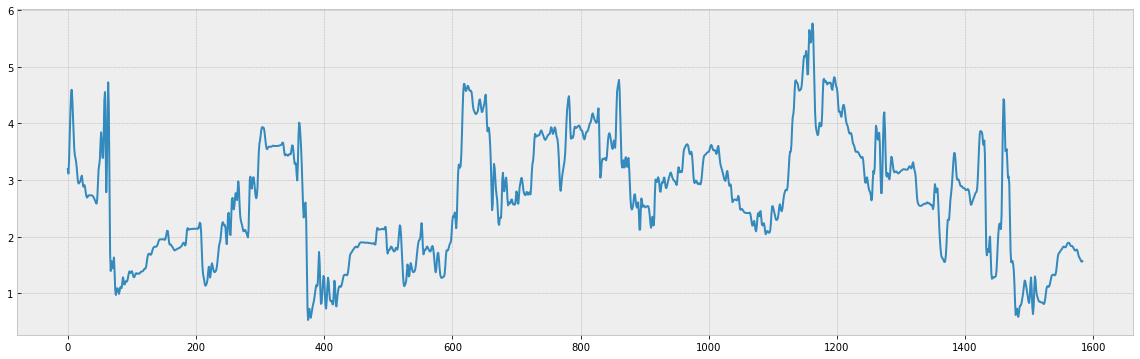

In [3]:
T_A = v.astype(np.float64)
m = 160
r = 8  #sakoe_chiba_radius
D = 2
T_B = None
# indices_pruned=np.arange(500, 600)
indices_pruned = None
ignore_trivial = True

l = len(T_A) - m + 1
# PAA
Ta_D = stumpy.paa(T_A, D).astype(np.float64)
m_D = int(m/D)
r_D = int(r/D) if r/D > 1 else 1

if indices_pruned is None:
    indices_pruned_D = None
else:
    indices_pruned_ = np.round(indices_pruned/D)
    indices_pruned_D = np.unique(indices_pruned_).astype(np.int64)

if T_B is None:
    out_dslb = stumpy.lbKeogh_MP(Ta_D, m_D, r_D, indices_pruned=indices_pruned_D)
else:
    Tb_D = stumpy.paa(T_B, D).astype(np.float64)
    out_dslb = stumpy.lbKeogh_MP(Ta_D, m_D, r_D, T_B=Tb_D, ignore_trivial=False)

# Cost rescaling
mp_D = out_dslb[0] * np.sqrt(D)
n_mp_D = len(mp_D)
x_mp = np.arange(n_mp_D)
x_D = np.linspace(0, n_mp_D-1, l)

# intrpolate to raw series length
if D >= 16: 
    f_interpolate = interpolate.interp1d
else:
    f_interpolate = interpolate.CubicSpline   

mask_inf = np.isinf(mp_D)
if np.sum(mask_inf) > 0:
    fitted_curve = f_interpolate(x_mp[~mask_inf], mp_D[~mask_inf])
    mp_i = fitted_curve(x_D)
    mp_i[indices_pruned] = np.inf
else:
    fitted_curve = f_interpolate(x_mp, mp_D)
    mp_i = fitted_curve(x_D)

plt.plot(mp_i)

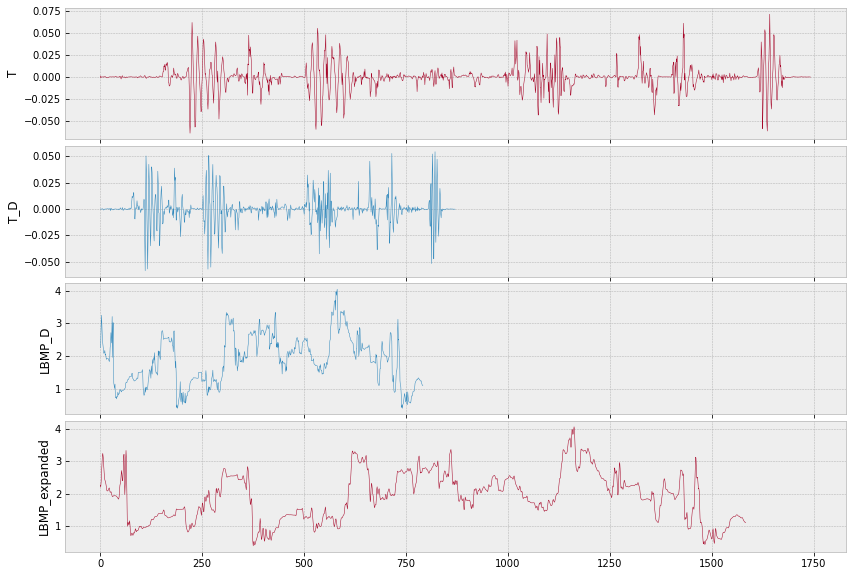

In [40]:
fig, axs = plt.subplots(4, 1, sharex=True, gridspec_kw={'hspace': 0.05}, figsize=(14, 10))
axs[0].plot(T_A, color="C1", linewidth=0.5)
axs[0].set_ylabel("T")

axs[1].plot(Ta_D, linewidth=0.5)
axs[1].set_ylabel("T_D")

axs[2].plot(mp_D, linewidth=0.5)
axs[2].set_ylabel("LBMP_D")

axs[3].plot(mp_i, color="C1", linewidth=0.5)
axs[3].set_ylabel("LBMP_expanded")
plt.show()

### with indices pruned

In [4]:
T_A = v.astype(np.float64)
m = 160
r = 8  #sakoe_chiba_radius
D = 2
T_B = None
indices_pruned= np.arange(500, 600)
mp_i = stumpy.lbKeogh_DSMP(T_A, m, D, r, indices_pruned=indices_pruned)

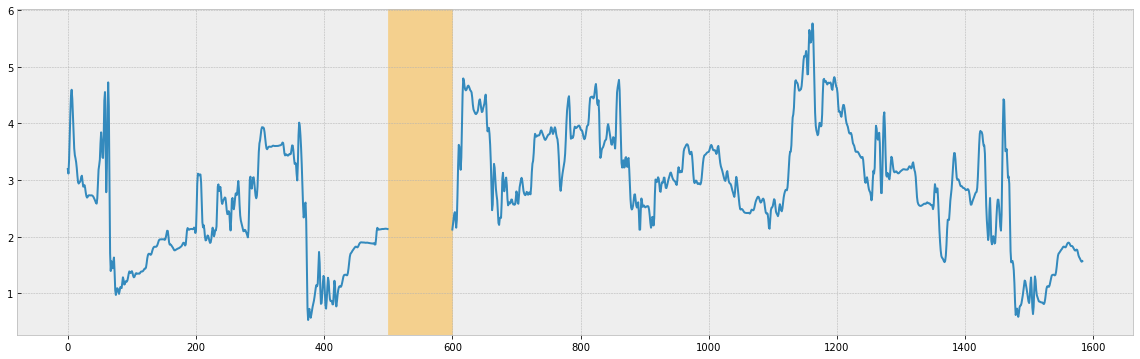

In [6]:
plt.plot(mp_i)
plt.axvspan(500, 600, color="orange", alpha=0.4)